In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from planar_code import PlanarLattice
from graph_operations import min_weight_syndrome_matching
from visualization import plot_matchings


BOUNDARIES = np.array((1,0), dtype=int)


def single_shot_correction(lattice):
    lattice.reset()
    lattice.apply_errors()
    syndrome = lattice.measure_syndrome()
    matching, paths = min_weight_syndrome_matching(lattice, syndrome, pathfinding='dijkstra')
    for path in paths:
        lattice.apply_edge_operators(path)
    try:
        return lattice.detect_logical_errors()
    except Exception as e:
        plot_matchings(lattice, syndrome, pathfinding='dijkstra')
        raise e


def logical_error_rate(p, L, samples=int(1e3), verbose=True):
    lattice = PlanarLattice(L, L, BOUNDARIES, p)
    logical_errors = []
    sample_range = tqdm(
        range(samples),
        desc=f'Calculating logical errors for p={round(p,3)} on length {L} square lattice'
    ) if verbose else range(samples)
    for _ in sample_range:
        logical_errors.append(single_shot_correction(lattice))
    return np.array(logical_errors)


def linear_sweep(L, domain=(0,1), points=100, samples_per_point=int(1e4)):
    p_array = np.linspace(*domain, points+2)
    logical_errors = []
    for p in tqdm(
        p_array,
        desc=f'L={L}: Sweeping {points} values over domain {[round(d, 3) for d in domain]}'
    ):
        logical_errors.append(logical_error_rate(p, L, samples=samples_per_point, verbose=False))
    return p_array, np.stack(logical_errors, axis=0)

In [2]:
SAVE_DIR = 'temp'
SAVED_FILES = []

In [3]:
for L in [4, 8]:
    fname = os.path.join(SAVE_DIR, f'{L}.csv')
    ps, a = linear_sweep(L, domain=(0,0.3), points=100, samples_per_point=1000)
    np.savetxt(fname, a)

L=4: Sweeping 100 values over domain [0, 0.3]:   0%|          | 0/102 [00:00<?, ?it/s]

L=8: Sweeping 100 values over domain [0, 0.3]:   0%|          | 0/102 [00:00<?, ?it/s]

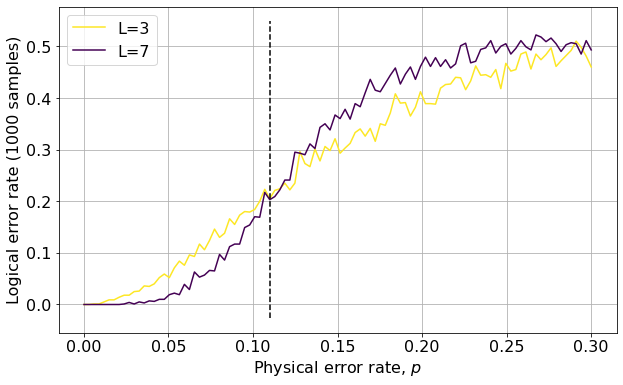

In [4]:
import matplotlib as mpl

plt.rcParams.update({'font.size': 16})
BATCH = 4

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.grid(True)
ax.set_xlabel('Physical error rate, $p$')
ax.set_ylabel('Logical error rate (1000 samples)')
#ax.set_xscale('log')
#ax.set_yscale('log')

files = []
for fname in os.listdir(SAVE_DIR):
    if not fname.endswith('.csv'):
        continue
    fpath = os.path.join(SAVE_DIR, fname)
    L = int(fname.split('.')[0])
    files.append([L, fpath])

files.sort()
min_l = min(files)[0]
max_l = max(files)[0]
norm = mpl.colors.Normalize(vmin=min_l, vmax=max_l, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis_r)
ps = np.linspace(0, 0.3, 102)
for L, fpath in files:
    error_array = np.loadtxt(fpath)
    mean_errors = error_array.mean(axis=-1)
    #ax.fill_between(xvals, yvals+error_stdev[-1], yvals-error_stdev[-1], alpha=0.3, zorder=1)
    ax.plot(ps, mean_errors, color=mapper.to_rgba(L), label=f'L={L-1}', zorder=2)
    

ax.vlines(0.11, *ax.get_ylim(), color='black', linestyle='dashed', zorder=3)
ax.legend()
# plt.savefig('temp/uniform_p_threshold.pdf', bbox_inches='tight')

In [3]:
import itertools
from collections import defaultdict

lattice_sizes = [3,4,5,6]
SAVE_DIR = 'temp'

for size in tqdm(lattice_sizes, desc='Lattices'):
    total_errors = defaultdict(int)
    totals = defaultdict(int)
    L = size + 1
    lattice = PlanarLattice(L, L, np.array((1,0), dtype=int), 0.05)
    L, W, D = lattice.edges.shape
    edges = list(itertools.product(range(L), range(W), range(D)))
    for r in range(1, L//2+1):
        for errors in tqdm(itertools.combinations(edges, r=r), desc=f'Length {r} errors'):
            totals[r] += 1
            lattice.reset()
            for edge in errors:
                lattice.apply_edge_operator(edge)
            syndrome = lattice.measure_syndrome()
            matching, paths = min_weight_syndrome_matching(lattice, syndrome, pathfinding='manhattan')
            for path in paths:
                lattice.apply_edge_operators(path)
            try:
                logical_errors = lattice.detect_logical_errors()
                if logical_errors > 0:
                    total_errors[r] += 1
            except:
                print(paths)
                plot_planar_code(planar_code, plot_dual=False, show_errors=True, show_syndrome=True)
            
    with open(os.path.join(SAVE_DIR, f'{size}.pkl'), 'wb') as f:
        pickle.dump(total_errors, f)
    with open(os.path.join(SAVE_DIR, f'{size}_totals.pkl'), 'wb') as f:
        pickle.dump(totals, f)

Lattices:   0%|          | 0/6 [00:00<?, ?it/s]

Length 1 errors: 0it [00:00, ?it/s]

Length 2 errors: 0it [00:00, ?it/s]

Length 1 errors: 0it [00:00, ?it/s]

Length 2 errors: 0it [00:00, ?it/s]

Length 1 errors: 0it [00:00, ?it/s]

Length 2 errors: 0it [00:00, ?it/s]

Length 3 errors: 0it [00:00, ?it/s]

Length 1 errors: 0it [00:00, ?it/s]

Length 2 errors: 0it [00:00, ?it/s]

Length 3 errors: 0it [00:00, ?it/s]

Length 1 errors: 0it [00:00, ?it/s]

Length 2 errors: 0it [00:00, ?it/s]

Length 3 errors: 0it [00:00, ?it/s]

Length 4 errors: 0it [00:00, ?it/s]

Length 1 errors: 0it [00:00, ?it/s]

Length 2 errors: 0it [00:00, ?it/s]

Length 3 errors: 0it [00:00, ?it/s]

Length 4 errors: 0it [00:00, ?it/s]

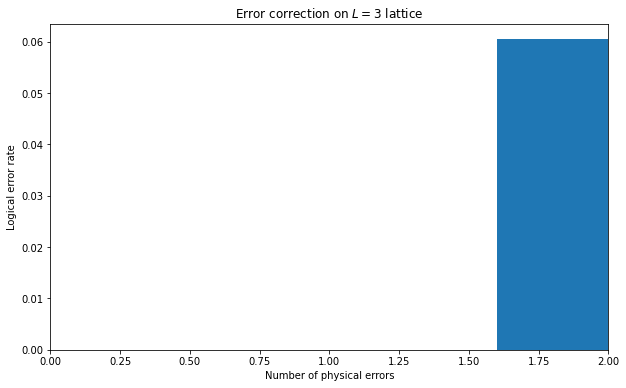

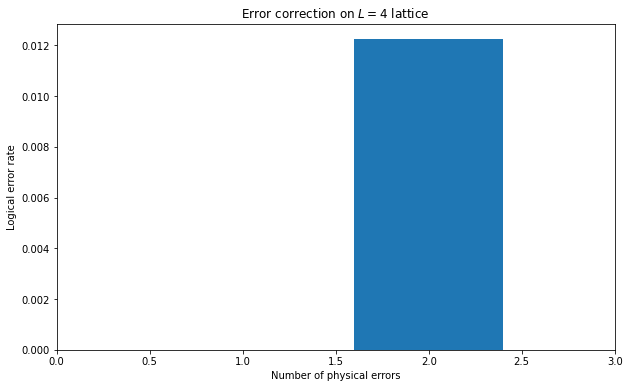

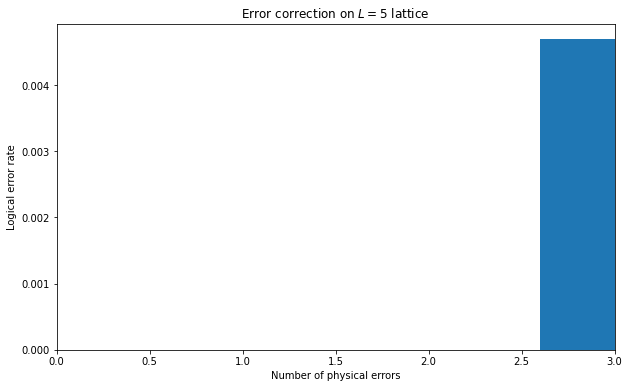

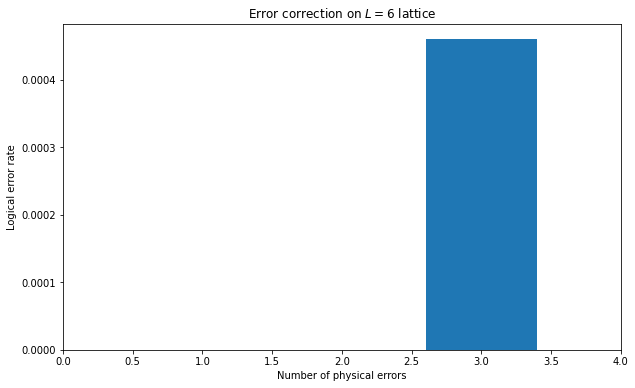

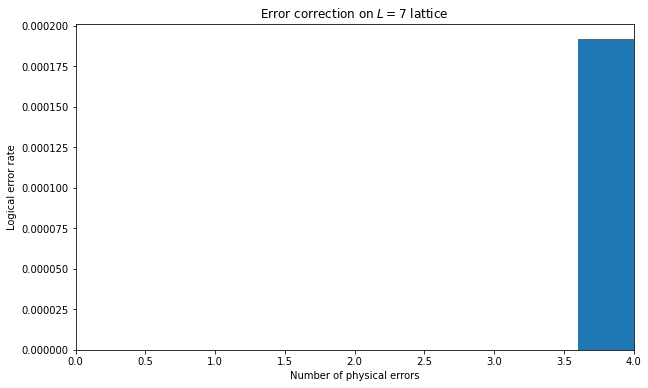

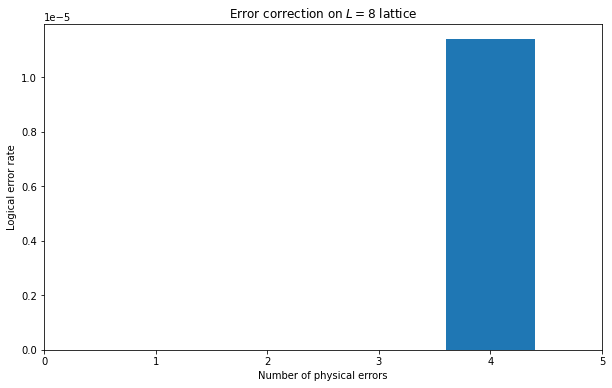

In [9]:
SAVE_DIR = 'temp'
lattice_sizes = [3,4,5,6,7,8]

for size in lattice_sizes:
    errors_file = f'{size}.pkl'
    totals_file = f'{size}_totals.pkl'
    efpath = os.path.join(SAVE_DIR, errors_file)
    tfpath = os.path.join(SAVE_DIR, totals_file)
    with open(efpath, 'rb') as ef, open(tfpath, 'rb') as tf:
        errors = pickle.load(ef)
        totals = pickle.load(tf)
        error_lengths = np.array(sorted(list(errors.keys())))
        error_rate = (
            np.array([errors[r] for r in error_lengths])
            / np.array([totals[r] for r in error_lengths]))
        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        ax.bar(error_lengths, error_rate)
        ax.set_xlabel('Number of physical errors')
        ax.set_xlim(0,size//2 + 1)
        ax.set_ylabel('Logical error rate')
        ax.set_title(f'Error correction on $L={size}$ lattice')